# 11wk-1: 추천시스템 (2) – Embedding 레이어, 사용자정의 네트워크,

NN-based 추천시스템

최규빈  
2024-05-14

<a href="https://colab.research.google.com/github/guebin/DL2024/blob/main/posts/11wk-1.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상

In [74]:
#{{<video https://youtu.be/playlist?list=PLQqh36zP38-xl7f2bcPTKMVCe3kHM380M&si=5SO7pni3fXX4kK-4 >}}

# 2. Imports

In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

# 3. `torch.nn.Embedding`

## A. 임베딩레이어

`-` 모티브: `torch.nn.functional.one_hot` + `torch.nn.Linear` 를 매번
쓰는건 너무 귀찮지 않어?

-   ${\boldsymbol x}= \begin{bmatrix} 0 \\ 1 \\ 2 \\ 0 \\ 1 \end{bmatrix} \Longrightarrow {\bf E}= \begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \\ 1 & 0 & 0 \\ 0 & 1 & 0 \end{bmatrix}$

-   $\text{linr}({\bf E})= \begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \\ 1 & 0 & 0 \\ 0 & 1 & 0 \end{bmatrix}\begin{bmatrix} -0.2002 \\ -0.4890 \\ 0.2081 \end{bmatrix} = \begin{bmatrix} -0.2002 \\ -0.4890 \\ 0.2081 \\ -0.2002 \\ -0.4890 \end{bmatrix}$

`-` `torch.nn.functional.one_hot` + `torch.nn.Linear` 를 함께처리해주는
레이어 `torch.nn.Embedding` 존재

-   $\text{ebdd}({\boldsymbol x})= \text{linr}\big(\text{onehot}({\boldsymbol x})\big) = \begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \\ 1 & 0 & 0 \\ 0 & 1 & 0 \end{bmatrix}\begin{bmatrix} -0.2002 \\ -0.4890 \\ 0.2081 \end{bmatrix} = \begin{bmatrix} -0.2002 \\ -0.4890 \\ 0.2081 \\ -0.2002 \\ -0.4890 \end{bmatrix}$

-   우리가 이전에 구현했던 코드 “onehot + linr” 와 “ebdd”는 정확하게
    동일한 동작을 수행함.

`-` 결론: 아래의 두개의 코드는 같다.

``` python
X = torch.tensor([0,1,2,0,1])

## 코드1 
linr = torch.nn.Linear(3,1) 
linr(torch.nn.functional.one_hot(X))

## 코드2 
ebdd = torch.nn.Embedding(3,1)
ebdd(X) 
```

`# 의문`: 그냥 원핫인코딩없이 바로 선형변환하면 안되나? (= 꼭
임베딩레이어를 써야하나?)

-   $\text{linr}({\bf X}) = \begin{bmatrix} 0 \\ 1 \\ 2 \\ 0 \\ 1 \end{bmatrix} \times (-0.3467) + (-0.8470)=\begin{bmatrix} -0.8470 \\ -1.1937 \\ -1.5404 \\ -0.8470 \\ -1.1937 \end{bmatrix}$

-   $\text{ebdd}({\boldsymbol x})= \text{linr}\big(\text{onehot}({\boldsymbol x})\big) = \begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \\ 1 & 0 & 0 \\ 0 & 1 & 0 \end{bmatrix}\begin{bmatrix} -0.8178 \\ -0.7052 \\ -0.5843 \end{bmatrix} = \begin{bmatrix} -0.8178 \\ -0.7052 \\ -0.5843 \\ -0.8178 \\ -0.7052 \end{bmatrix}$

`-` 데이터를 읽으며 해석: 사실상 0,1,2에 대한 의미는
“옥순”,“영숙”,“하니” 같은 자료였고, 임베딩의 결과는
“옥순”,“영숙”,“하니”가 가지는 어떠한 특징이었음 (예를들면 매력같은).
데이터를 상상하며 위의 결과를 다시 해석해보자.

-   옥순이 가지는 어떠한 특징 (-0.8470 혹은 -0.8178) 을 바꾸고 싶다면?
    `ebdd`의 경우 -0.8178 이라는 숫자를 조정하면 된다. 이 조정은 옥순의
    특징만 바꾸며 영숙과 하니의 특징은 바꾸지 않는다. 반면 `linr`의 경우
    -0.3467 혹은 -0.8470 을 조정하면 되는데, 이는 옥순의 특징을 바꿈과
    동시에 영숙과 하니의 특징까지 같이 바꾼다. 하니, 혹은 영숙이 가지는
    특징을 바꾸고 싶을 경우도 마찬가지 현상이 일어남.
-   만약에 출연자가 1000명이라면 `linr`그 1000명의 특징을 단 2개의
    파라메터로 조정해야한다. (그리고 하나를 바꾸면 999명이 같이 바뀐다)
    하지만 `ebdd`는 1000개의 특징을 조정할 수 있는 1000개의 파라메터를
    확보할 수 있게 된다.

`-` 결론: ebdd가 더 파라메터 조정을 통하여 특징을 학습하기 용이하다.
(독립적으로 특징값을 줄 수 있으니까!)

> 만약에 문자열이 “최우수(A)”, “우수(B)”, “보통(C)”, “미흡(D)”,
> “매우미흡(F)” 이었다면 특징을 뽑아낼때 linr 가 더 적절했겠죠?

## B. MF-based 추천시스템 재설계

In [2]:
df_view = pd.read_csv('https://raw.githubusercontent.com/guebin/DL2024/main/posts/solo.csv',index_col=0)
df_view

In [3]:
df_train = df_view.stack().reset_index().set_axis(['W','M','y'],axis=1)
w = {'옥순(IN)':0, '영자(IN)':1, '정숙(IS)':2, '영숙(IS)':3, '순자(EN)':4, '현숙(EN)':5, '서연(ES)':6, '보람(ES)':7, '하니(I)':8}
m = {'영식(IN)':0, '영철(IN)':1, '영호(IS)':2, '광수(IS)':3, '상철(EN)':4, '영수(EN)':5, '규빈(ES)':6, '다호(ES)':7}
X1 = torch.tensor(df_train['W'].map(w)) # length-n int vector 
X2 = torch.tensor(df_train['M'].map(m)) # length-n int vector 
y = torch.tensor(df_train['y']).float().reshape(-1,1) # (n,1) float vector

# 4. 사용자정의 네트워크

## A. 사용자정의 네트워크 사용법

`# 예비학습1`: net(x)와 사실 net.forward(x)는 같다.

그래서 net.forward를 재정의하면 net(x)의 기능을 재정의 할 수 있다.

`#`

`# 예비학습2`: `torch.nn.Module`을 상속받아서 네트워크를 만들면 (=
“`class XXX(torch.nn.Module):`” 와 같은 방식으로 클래스를 선언하면)
약속된 아키텍처를 가진 네트워크를 찍어내는 함수를 만들 수 있다.

(예시1)

In [44]:
class Mynet1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = torch.nn.Linear(in_features=1,out_features=1,bias=True)
        self.a1 = torch.nn.Sigmoid()
        self.l2 = torch.nn.Linear(in_features=1,out_features=1,bias=False)
    def forward(self,x):
        yhat = self.l2(self.a1(self.l1(x)))
        return yhat

이제

``` python
net = Mynet1()
```

는 아래와 같은 효과를 가진다.

``` python
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=1,bias=True),
    torch.nn.Sigmoid(),
    torch.nn.Linear(in_features=1,out_features=1,bias=False)
)
```

(예시2)

In [45]:
class Mynet2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = torch.nn.Linear(in_features=1,out_features=1,bias=True)
        self.a1 = torch.nn.ReLU()
        self.l2 = torch.nn.Linear(in_features=1,out_features=1,bias=False)
    def forward(self,x):
        yhat = self.l2(self.a1(self.l1(x)))
        return yhat

이제

``` python
net = Mynet2()
```

는 아래와 같은 효과를 가진다.

``` python
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=1,bias=True),
    torch.nn.RuLU(),
    torch.nn.Linear(in_features=1,out_features=1,bias=False)
)
```

***클래스에 대한 이해가 부족한 학생을 위한 암기방법***

**step1:** 아래와 코드를 복사하여 틀을 만든다. (이건 무조건 고정임, XXXX
자리는 원하는 이름을 넣는다)

``` python
class XXXX(torch.nn.Module):
    def __init__(self):
        super().__init__()
        ## 우리가 yhat을 구할때 사용할 레이어를 정의 
        
        ## 정의 끝
    def forward(self,X):
        ## yhat을 어떻게 구할것인지 정의 
        
        ## 정의 끝
        return yhat
```

-   net(X)에 사용하는 X임, yhat은 net.forward(X) 함수의 리턴값임
-   사실, X/yhat은 다른 변수로 써도 무방하나 (예를들면 input/output
    이라든지, netin/netout 이라든지) 설명의 편의상 X와 yhat을 고정한다.

**step2:** `def __init__(self):`에 yhat을 구하기 위해 필요한 재료를
레이어를 정의하고 이름을 붙인다. 이름은 항상 `self.xxx` 와 같은 식으로
정의한다.

``` python
class XXXX(torch.nn.Module):
    def __init__(self):
        super().__init__()
        ## 우리가 yhat을 구할때 사용할 레이어를 정의 
        self.xxx1 = torch.nn.Linear(in_features=1,out_features=1,bias=True)
        self.xxx2 = torch.nn.Sigmoid()
        self.xxx3 = torch.nn.Linear(in_features=1,out_features=1,bias=True)
        ## 정의 끝
    def forward(self,X):
        ## yhat을 어떻게 구할것인지 정의 
        
        ## 정의 끝
        return yhat
```

**step3:** `def forward:`에 “X –\> yhat” 으로 가는 과정을 묘사한 코드를
작성하고 yhat을 리턴하도록 한다.

``` python
class XXXX(torch.nn.Module):
    def __init__(self):
        super().__init__()
        ## 우리가 yhat을 구할때 사용할 레이어를 정의 
        self.xxx1 = torch.nn.Linear(in_features=1,out_features=1,bias=True)
        self.xxx2 = torch.nn.Sigmoid()
        self.xxx3 = torch.nn.Linear(in_features=1,out_features=1,bias=True)
        ## 정의 끝
    def forward(self,X):
        ## yhat을 어떻게 구할것인지 정의 
        u = self.xxx1(X) 
        v = self.xxx2(u)
        yhat = self.xxx3(v) 
        ## 정의 끝
        return yhat
```

`#`

`# 실습`: 사용자정의 네트워크를 사용하여 아래의 자료를 학습해보자.

In [46]:
torch.manual_seed(43052)
x,_ = torch.randn(100).sort()
x = x.reshape(-1,1)
ϵ = torch.randn(100).reshape(-1,1)*0.5
y = 2.5+ 4*x + ϵ

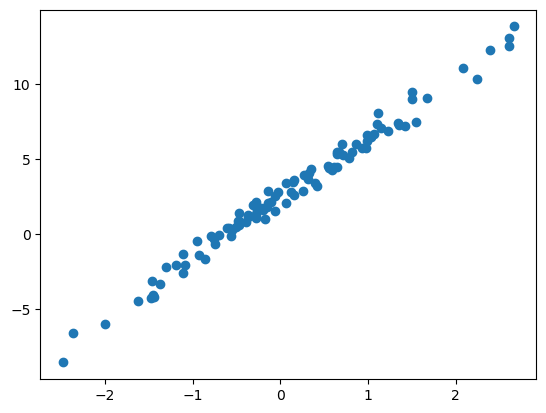

In [47]:
plt.plot(x,y,'o')

(풀이)

`#`

## B. MF-based 추천시스템 재설계

아래의 자료를 활용하여 추천시스템을 설계하고자한다.

In [53]:
df_view = pd.read_csv('https://raw.githubusercontent.com/guebin/DL2024/main/posts/solo.csv',index_col=0)
df_view

In [54]:
df_train = df_view.stack().reset_index().set_axis(['W','M','y'],axis=1)
w = {'옥순(IN)':0, '영자(IN)':1, '정숙(IS)':2, '영숙(IS)':3, '순자(EN)':4, '현숙(EN)':5, '서연(ES)':6, '보람(ES)':7, '하니(I)':8}
m = {'영식(IN)':0, '영철(IN)':1, '영호(IS)':2, '광수(IS)':3, '상철(EN)':4, '영수(EN)':5, '규빈(ES)':6, '다호(ES)':7}
X1 = torch.tensor(df_train['W'].map(w)) # length-n int vector 
X2 = torch.tensor(df_train['M'].map(m)) # length-n int vector 
y = torch.tensor(df_train['y']).float().reshape(-1,1) # (n,1) float vector

사용자정의 네트워크를 이용하여 MF-based 추천시스템을 설계하라.

(풀이1) – `net(X1,X2)`

(풀이2) – `net(X)`

# 5. NN-based 추천시스템

## A. NN-based 방식

아래의 자료를 활용하여 추천시스템을 설계하고자한다.

In [63]:
df_view = pd.read_csv('https://raw.githubusercontent.com/guebin/DL2024/main/posts/solo.csv',index_col=0)
df_view

In [64]:
df_train = df_view.stack().reset_index().set_axis(['W','M','y'],axis=1)
w = {'옥순(IN)':0, '영자(IN)':1, '정숙(IS)':2, '영숙(IS)':3, '순자(EN)':4, '현숙(EN)':5, '서연(ES)':6, '보람(ES)':7, '하니(I)':8}
m = {'영식(IN)':0, '영철(IN)':1, '영호(IS)':2, '광수(IS)':3, '상철(EN)':4, '영수(EN)':5, '규빈(ES)':6, '다호(ES)':7}
X1 = torch.tensor(df_train['W'].map(w)) # length-n int vector 
X2 = torch.tensor(df_train['M'].map(m)) # length-n int vector 
y = torch.tensor(df_train['y']).float().reshape(-1,1) # (n,1) float vector

**소망**: NN-based 모델로 만들어 보고싶다.

(풀이1) – 실패

(풀이2) – 에라 모르겠다 깊은신경망..

(영자-다호), (보람-다호), (하니-영호) 를 예측해보자.

## B. NCF (He et al. 2017)

![](https://github.com/guebin/DL2024/blob/main/posts/NCF.png?raw=true)

He, Xiangnan, Lizi Liao, Hanwang Zhang, Liqiang Nie, Xia Hu, and
Tat-Seng Chua. 2017. “Neural Collaborative Filtering.” In *Proceedings
of the 26th International Conference on World Wide Web*, 173–82.